In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
import models
from visualize import *
from data import *
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
data_path = './cosmo'

# load dataset and model

In [3]:
# params
img_size = 256
class_num = 1

# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(opj(data_path, 'cosmological_parameters.txt'),  
                              opj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=True, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

In [25]:
class Transform(nn.Module):
    def __init__(self):
        super(Transform, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)  
#         self.conv2 = nn.Conv2d(32, 10, kernel_size=4, stride=1, padding=1, bias=False)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x, indices = self.pool(x)
        x = self.unpool(x, indices)
        # add second hidden layer
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)  # compressed representation
                
        return x
    
class Transform_i(nn.Module):
    def __init__(self):
        super(Transform_i, self).__init__()        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
#         self.t_conv1 = nn.ConvTranspose2d(10, 32, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)
        self.t_conv1 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0, output_padding=0, bias=False)
#         self.u_conv1 = nn.Conv2d(10, 32, kernel_size=7, padding=0)
#         self.u_conv1 = nn.Conv2d(32, 1, kernel_size=3, padding=1)


    def forward(self, x):
        ## decode ##
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `upsample` in some PyTorch versions
#         x = F.interpolate(x, scale_factor=4, mode='nearest')
        x = self.t_conv1(x)
        # upsample again, output should have a sigmoid applied
#         x = F.interpolate(x, scale_factor=3, mode='nearest')
#         x = self.u_conv2(x)
                
        return x


In [26]:
# def transforms
t = Transform().to(device)
transform_i = Transform_i().to(device)
# transform_i.load_state_dict(torch.load('./models/conv_filters_pen'))

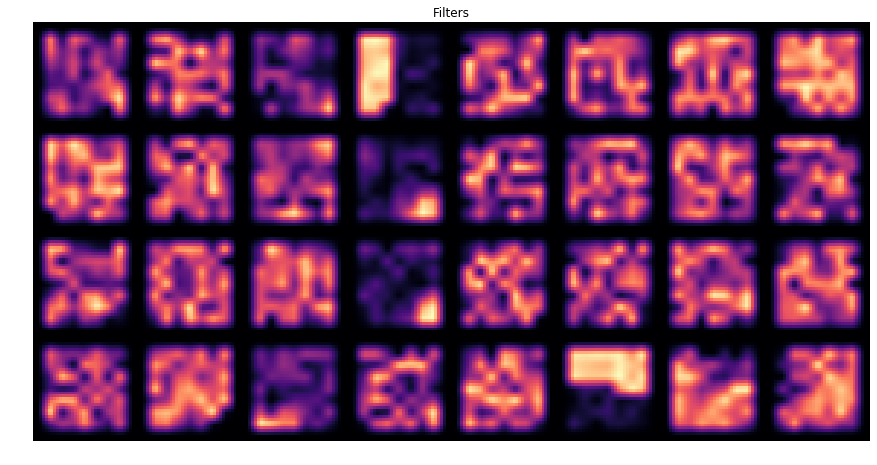

In [70]:
# viz filters
t.load_state_dict(torch.load('./models/transform_'))
viz_filters(t.conv1.weight, normalize=True)

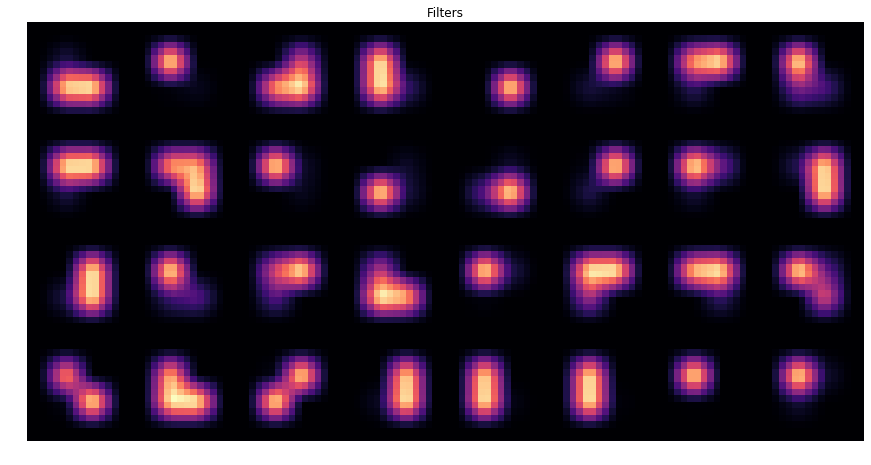

In [71]:
# viz filters
transform_i.load_state_dict(torch.load('./models/transform_i_'))
viz_filters(transform_i.t_conv1.weight, normalize=True)

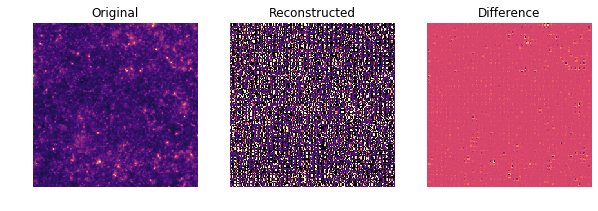

53.74843791826766


In [74]:
im = mnu_dataset[25000]['image'].to(device).unsqueeze(0)
viz_im_r(im, transform_i(t(im)))
print(torch.norm(im - transform_i(t(im))).item()**2/28**2)

## Mask 


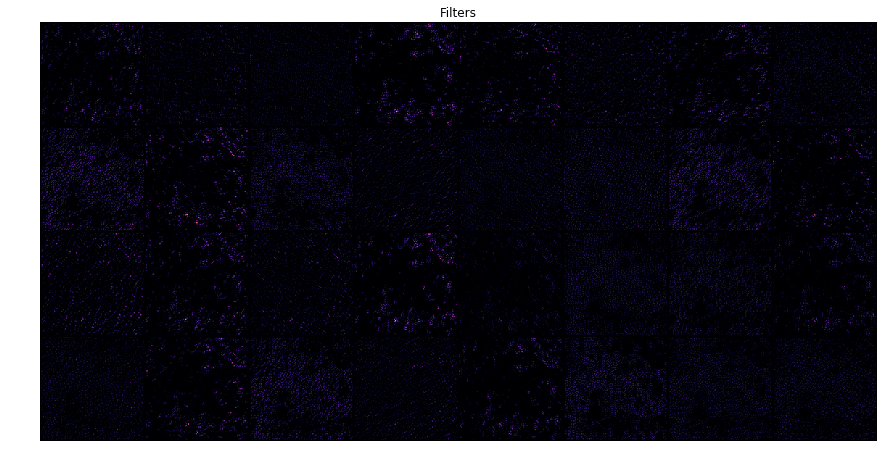

In [39]:
# viz filters
viz_filters(t(im), normalize=False)

In [10]:
class Mask(nn.Module):
    def __init__(self, img_size=128):
        super(Mask, self).__init__()
        self.img_size = img_size
        self.initialize()
#         self.mask = nn.Parameter(torch.clamp(abs(torch.randn(img_size, img_size)), 0, 1))
        
    def forward(self, x):
        return torch.mul(self.mask, x)   
    
    def initialize(self):
        self.mask = nn.Parameter(torch.ones(64, 32, self.img_size, self.img_size))

In [11]:
# mask
mask = Mask().to(device)

# criterion
criterion = nn.MSELoss()

# l1-loss
l1loss = nn.L1Loss()

# Setup Adam optimizer
optimizer = optim.Adam(mask.parameters(), lr=0.1)

# freeze params
for param in t.parameters():
    param.requires_grad = False
    
# images
ims = iter(data_loader).next()['image'].to(device)
X = t(ims)    

In [12]:
# Training Loop
# Lists to keep track of progress
losses = []
num_epochs = 100

lamb_l1 = 60.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    im_mask = mask(X)
    output_ = model(transform_i(im_mask))
    # loss
    loss = -output_[:,1].sum() + lamb_l1 * l1loss(mask.mask, torch.zeros_like(mask.mask))
    # zero grad
    optimizer.zero_grad()
    # backward
    loss.backward()
    # Update G
    optimizer.step()
    # projection
    mask.mask.data = torch.clamp(mask.mask.data, 0, 1)

    # Output training stats
    print('\rTrain Epoch: {}/{}'.format(epoch, num_epochs), end='')

    # Save Losses for plotting later
    losses.append(loss.item())


Starting Training Loop...
Train Epoch: 16/500

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
mask.mask.shape

In [ ]:
# viz filters
viz_filters(mask.mask[0:1], normalize=True)

In [ ]:
# viz filters
viz_filters(transform_i(mask(X)), normalize=False, vmax=0.15, vmin=-0.05)

In [ ]:
# viz filters
viz_filters(ims, normalize=False, vmax=0.15, vmin=-0.05)